#COS 575 Lab 7
##Tatiana Romanchishina

####We will continue to try to predict Premature Death Value in the chr2015 dataset. There are a lot of features in the CHR dataset & it is often useful to identify the most important predictors. 

####Try out one of the regression methods explored in this chapter, such as best subset selection, the lasso, and ridge regression. Present and discuss results for the approaches that you consider. 

####If you are getting an error regarding an invalid float, check to make sure you have performed the steps to clean up the data provided in Lab 2.

In [1]:
# load numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline

from pylab import *

# load statsmodels
import statsmodels.api as sm

from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn.lda import LDA
from sklearn.neighbors import KNeighborsClassifier

from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from patsy import dmatrices
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.feature_selection import RFE

import scipy as scipy
import six as six

import sys
sys.path.append('/Users/tatiana/anaconda/pkgs/seaborn-0.6.0-np110py34_0/lib/python3.4/site-packages')
import seaborn as sns


# load the data
path = r'CHR2015.csv'
df = pd.read_csv(path)
df.head()

,STATECODE,COUNTYCODE,State,County,Premature_death_Value,Poor_or_fair_health_Value,Poor_physical_health_days_Value,Poor_mental_health_days_Value,Low_birthweight_Value,Adult_smoking_Value,...,Uninsured_adults_Value,Uninsured_children_Value,Health_care_costs_Value,Could_not_see_doctor_due_to_cost_Value,Other_primary_care_providers_Value,Median_household_income_Value,Children_eligible_for_free_lunch_Value,Homicide_rate_Value,bottom10,top10
0,1,0,AL,Alabama,9508,0.205,4.3,4.3,0.10,0.219,...,0.202,0.043,10127,0.163,48,42882,0.500,9.1,0,0
1,1,1,AL,Autauga County,8405,0.228,5.1,3.6,0.09,0.217,...,0.169,0.037,9939,0.156,18,51868,0.383,4.6,0,0
2,1,3,AL,Baldwin County,7457,0.127,3.3,3.8,0.09,0.206,...,0.199,0.054,9502,0.144,29,47539,0.344,4.3,0,0
3,1,5,AL,Barbour County,8901,0.234,4.8,4.3,0.12,0.251,...,0.228,0.045,10414,0.169,11,30981,0.697,NaN,0,0
4,1,7,AL,Bibb County,10729,0.179,4.7,5.1,0.13,0.259,...,0.193,0.042,10825,0.163,9,39781,0.546,7.8,0,0


In [2]:
# remove all nas
df_n = df.dropna()
# not a lot of rows left
df_n = df_n.reset_index(drop=True)

print(round(len(df_n)/len(df)*100), "% of rows left")

29 % of rows left


In [170]:
# remove some columns
rm_col = ['County','COUNTYCODE','bottom10','top10','Premature_age']#,'Premature_death_Value']
columns = list(df_n.columns.values)
columns = list(set(columns)-set(rm_col))

colnames_w_digits = [x for x in df_n.columns if x[0].isdigit()]
columns = list(set(columns)-set(colnames_w_digits))

df_n = df_n[columns]

df_n = df_n.reset_index(drop=True)

In [173]:
#y = df_n['Premature_death_Value']  # response

predictors = "+".join(df_n.columns-["Premature_death_Value"])
# create dataframes with an intercept column
formula = 'Premature_death_Value~'+ predictors
#y, X = dmatrices(formula, df_n, return_type="dataframe")
# flatten y into a 1-D array
#y = np.ravel(y) #OR
#y = np.array(y.values.flatten())

#X_c = sm.add_constant(X)  # Adds a constant term to the predictor 
#type(y)
#model = sm.OLS(y, X_c)
#model = model.fit()
#model.score()

//anaconda/lib/python3.4/site-packages/pandas/core/index.py:1353: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  "use .difference()",FutureWarning)


###Get the best predictors

In [3]:
## clean up the predictors and response
df_fix = df[~np.isnan(df.Adult_smoking_Value) & ~np.isnan(df.Adult_obesity_Value) &
           ~np.isnan(df.Physical_inactivity_Value) & ~np.isnan(df.Diabetes_Value) &
            ~np.isnan(df.Teen_births_Value) & ~np.isnan(df.Premature_death_Value)]
df_fix = df_fix.reset_index(drop=True)
df_fix[['Adult_smoking_Value', 'Adult_obesity_Value', 'Physical_inactivity_Value', 
             'Diabetes_Value', 'Teen_births_Value']].isnull().sum()

Adult_smoking_Value          0
Adult_obesity_Value          0
Physical_inactivity_Value    0
Diabetes_Value               0
Teen_births_Value            0
dtype: int64

In [12]:
# create dataframes with an intercept column
y, X = dmatrices('Premature_death_Value ~ Adult_smoking_Value + Adult_obesity_Value + \
                 Physical_inactivity_Value + Diabetes_Value + \
                 Teen_births_Value',
                df_fix, return_type="dataframe")
# flatten y into a 1-D array
# y = np.ravel(y) #OR
y = y.values.flatten()

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

##Ridge Regression

In [57]:
train_error = np.empty(100)
test_error = np.empty(100)

alphas = [0.1**(-x) for x in np.arange(-10,0,1)]

for i in range(100):
    ridge = linear_model.RidgeCV(alphas = alphas)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    ridge.fit(X_train, y_train)
    train_error[i] = mean_squared_error(y_train, ridge.predict(X_train))
    test_error[i] = mean_squared_error(y_test, ridge.predict(X_test))

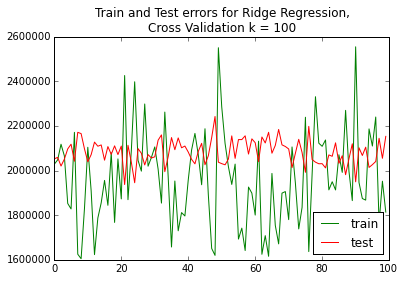

In [52]:
# test error is much more consistent than training error
plt.plot(np.arange(100), train_error, color='green', label='train')
plt.plot(np.arange(100), test_error, color='red', label='test')
plt.title("Train and Test errors for Ridge Regression,\nCross Validation k = 100")
plt.legend(loc='lower right')

##Lasso Regression

In [55]:
train_error = np.empty(100)
test_error = np.empty(100)

alphas = [0.1**(-x) for x in np.arange(-10,0,1)]

for i in range(100):
    lasso = linear_model.LassoCV(alphas = alphas)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
    ridge.fit(X_train, y_train)
    train_error[i] = mean_squared_error(y_train, ridge.predict(X_train))
    test_error[i] = mean_squared_error(y_test, ridge.predict(X_test))

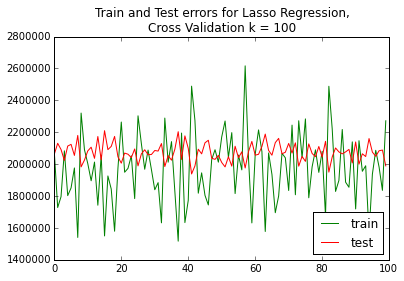

In [56]:
# test error is much more consistent than training error
plt.plot(np.arange(100), train_error, color='green', label='train')
plt.plot(np.arange(100), test_error, color='red', label='test')
plt.title("Train and Test errors for Lasso Regression,\nCross Validation k = 100")
plt.legend(loc='lower right')

####Propose a model (or set of models) that seem to perform well on this data set, and justify your answer. Make sure that you are evaluating model performance using validation set error, cross-validation, or some other reasonable alternative, as opposed to using training error. Does your chosen model involve all of the features in the dataset? Why or why not? 

After applying cross validation with k = 100, ridge regression and lasso regression models seem to perform with similar scores. However the lasso regression performed better, thus we will use it if we are faced with the choice.
I am using 5 predictors, previously picked as significant.

####Gradient Descent : Read and run this Gradient Descent Tutorial Redo one (or a few) of the Linear regressions you did in Lab 4 using Gradient Descent as the solution. Provide an evaluation of the model (r^2) and compare to the results from Lab 4.

In [16]:
# turn of data table rendering
pd.set_option('display.notebook_repr_html', False)

sns.set_palette(['#00A99D', '#F5CA0C', '#B6129F', '#76620C', '#095C57'])
sys.version

'3.4.3 |Anaconda 2.3.0 (x86_64)| (default, Mar  6 2015, 12:07:41) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [22]:
df_fix = df[~np.isnan(df.Premature_death_Value) & ~np.isnan(df.Adult_obesity_Value) &
           ~np.isnan(df.Diabetes_Value) & ~np.isnan(df.Homicide_rate_Value) &
            ~np.isnan(df.Limited_access_to_healthy_foods_Value) & ~np.isnan(df.Uninsured_Value) &
           ~np.isnan(df.Median_household_income_Value)]
X = df_fix[['Adult_obesity_Value', 'Diabetes_Value', 'Homicide_rate_Value', 
            'Limited_access_to_healthy_foods_Value',
            'Uninsured_Value', 'Median_household_income_Value']]
y = df_fix['Premature_death_Value']
#y, X = dmatrices('Premature_death_Value ~ Adult_obesity_Value + \
                # Diabetes_Value + Homicide_rate_Value + Uninsured_Value + \
                # Limited_access_to_healthy_foods_Value + Median_household_income_Value',
                # df_fix, return_type="dataframe")
# flatten y into a 1-D array
#y = np.ravel(y) #OR
#y = y.values.flatten()

# Feature scaling and mean normalization 
# standardizing the y-values from the data set
mean_y = y.mean()
sigma_y = y.std()
# standardize
y = y.apply(lambda y: (y-mean_y) / sigma_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=.2, random_state=1)


In [13]:
X_train.describe()

,Intercept,Adult_obesity_Value,Diabetes_Value,Homicide_rate_Value,Uninsured_Value,Limited_access_to_healthy_foods_Value,Median_household_income_Value
count,1026,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,1,0.306575,0.110915,6.344055,0.175063,0.072683,47734.273879
std,0,0.049256,0.024663,4.926602,0.050666,0.048598,13507.545678
min,1,0.142000,0.045000,0.700000,0.029000,0.000000,22674.000000
25%,1,0.276000,0.092250,3.100000,0.137000,0.042000,38646.750000
50%,1,0.309000,0.110000,4.950000,0.177000,0.062000,44469.500000
75%,1,0.340000,0.128000,7.900000,0.207750,0.091000,53970.750000
max,1,0.481000,0.216000,48.000000,0.386000,0.441000,117680.000000


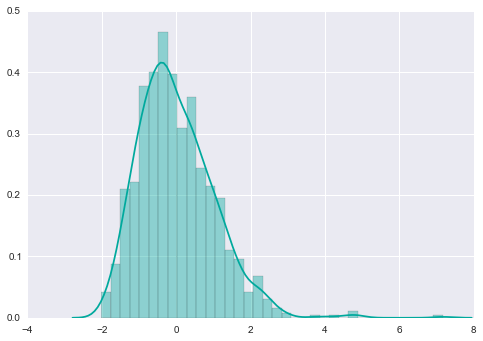

In [18]:
# Plot the distribution of response
sns.distplot(y_train)
plt.show()

In [25]:
# 1. Normalize our feature set x
#features = training_set[['gender', 'agerange', 'headsize']]
#observations = training_set['brainweight']
mu = X_train[['Adult_obesity_Value', 'Diabetes_Value', 'Homicide_rate_Value', 
            'Limited_access_to_healthy_foods_Value',
            'Uninsured_Value', 'Median_household_income_Value']].mean()
sigma = X_train[['Adult_obesity_Value', 'Diabetes_Value', 'Homicide_rate_Value', 
            'Limited_access_to_healthy_foods_Value',
            'Uninsured_Value', 'Median_household_income_Value']].std()

X_train_norm = (X_train[['Adult_obesity_Value', 'Diabetes_Value', 'Homicide_rate_Value', 
            'Limited_access_to_healthy_foods_Value',
            'Uninsured_Value', 'Median_household_income_Value']] - mu) / sigma
X_train_norm.head()

      Adult_obesity_Value  Diabetes_Value  Homicide_rate_Value  \
1133             1.876421        2.720046             1.452511   
2452            -0.742551       -0.523665            -0.902053   
2729            -2.671251       -2.348252            -0.962947   
57               0.719201        1.179283             1.269830   
164              0.841014       -0.037108            -0.658477   

      Limited_access_to_healthy_foods_Value  Uninsured_Value  \
1133                               1.364608         0.827702   
2452                              -0.919452        -1.836789   
2729                              -1.475035        -1.402575   
57                                 0.109404        -0.178883   
164                               -0.281562         0.650070   

      Median_household_income_Value  
1133                      -1.390576  
2452                       3.368986  
2729                       3.982865  
57                        -0.886340  
164                       -0

In [28]:
# 2. Intercept is already there

In [29]:
# 3. Set the initial alpha and number of iterations
alpha = 0.25
iterations = 150
m = len(y_train) * 1.0

# 4. Initialize the theta values to zero
thetas = np.zeros(len(X_train_norm.columns))
thetas

array([ 0.,  0.,  0.,  0.,  0.,  0.])

In [30]:
features_norm = np.array(X_train_norm)
observations = np.array(y_train)

cost_history = []

for i in range(iterations):
    # Calculate the predicted values
    predicted = np.dot(features_norm, thetas)

    # Calculate the theta's for this iteration:
    thetas -= (alpha / m) * np.dot((predicted - observations), features_norm)
    
    # Calculate cost
    sum_of_square_errors = np.square(predicted - observations).sum()
    cost = sum_of_square_errors / (2 * m)

    # Append cost to history
    cost_history.append(cost)
    
thetas

array([ 0.10245478,  0.30512401,  0.27108501,  0.06657049,  0.05036552,
       -0.30072326])

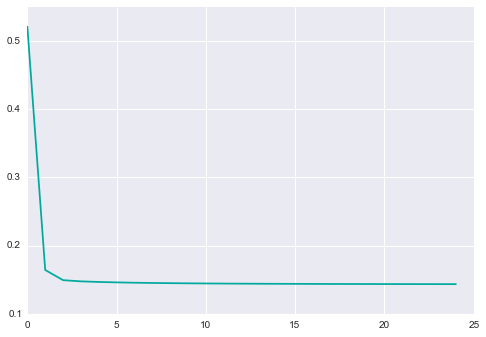

In [31]:
# Plot the last 25 entries of the cost history  
plt.plot(cost_history[:25])
plt.show()

In [37]:
# Calculate the predicted brainweights and differences from the observed values
X_train_norm['predictions'] = np.dot(features_norm, thetas)
X_train_norm['difference'] = X_train_norm['predictions'] - y_train
X_train_norm.head()

      Adult_obesity_Value  Diabetes_Value  Homicide_rate_Value  \
1133             1.876421        2.720046             1.452511   
2452            -0.742551       -0.523665            -0.902053   
2729            -2.671251       -2.348252            -0.962947   
57               0.719201        1.179283             1.269830   
164              0.841014       -0.037108            -0.658477   

      Limited_access_to_healthy_foods_Value  Uninsured_Value  \
1133                               1.364608         0.827702   
2452                              -0.919452        -1.836789   
2729                              -1.475035        -1.402575   
57                                 0.109404        -0.178883   
164                               -0.281562         0.650070   

      Median_household_income_Value  predictions  difference  
1133                      -1.390576     1.966663    0.242571  
2452                       3.368986    -1.647245    0.113839  
2729                       3.

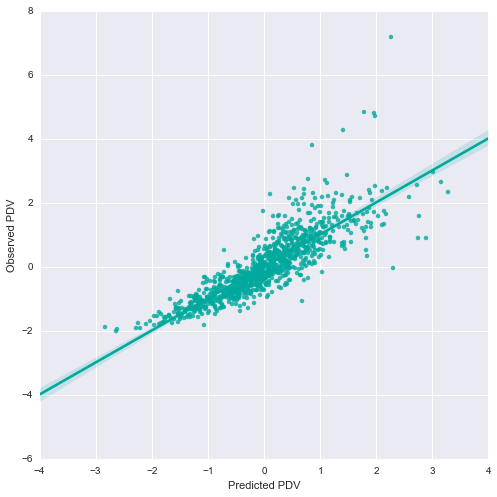

In [39]:
# Plot the predicted against the observed values
X_train_norm['actual'] = y_train
p = sns.lmplot("predictions", "actual", data = X_train_norm, size=7)
p.set_axis_labels("Predicted PDV", "Observed PDV")
plt.show()

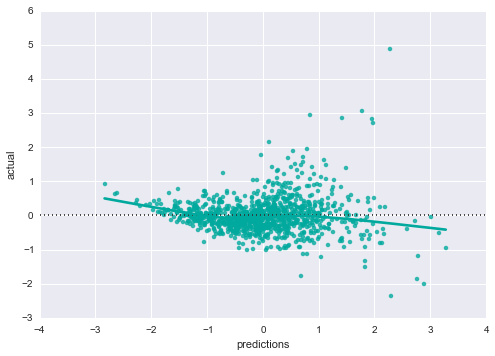

In [40]:
# Plot the residuals
p = sns.residplot(X_train_norm.predictions, 
                  X_train_norm.actual, lowess=True)
plt.show()

In [42]:
# Calculate the coefficient of determination (r^2)
y = np.array(X_train_norm.actual)
p = np.array(X_train_norm.predictions)
xbar = np.mean(y)

r_squared = 1 - np.square(y - p).sum() / np.square(y - xbar).sum()

## The R^2 value seems to be the same as achieved in Lab 4
r_squared

0.72480299133765036